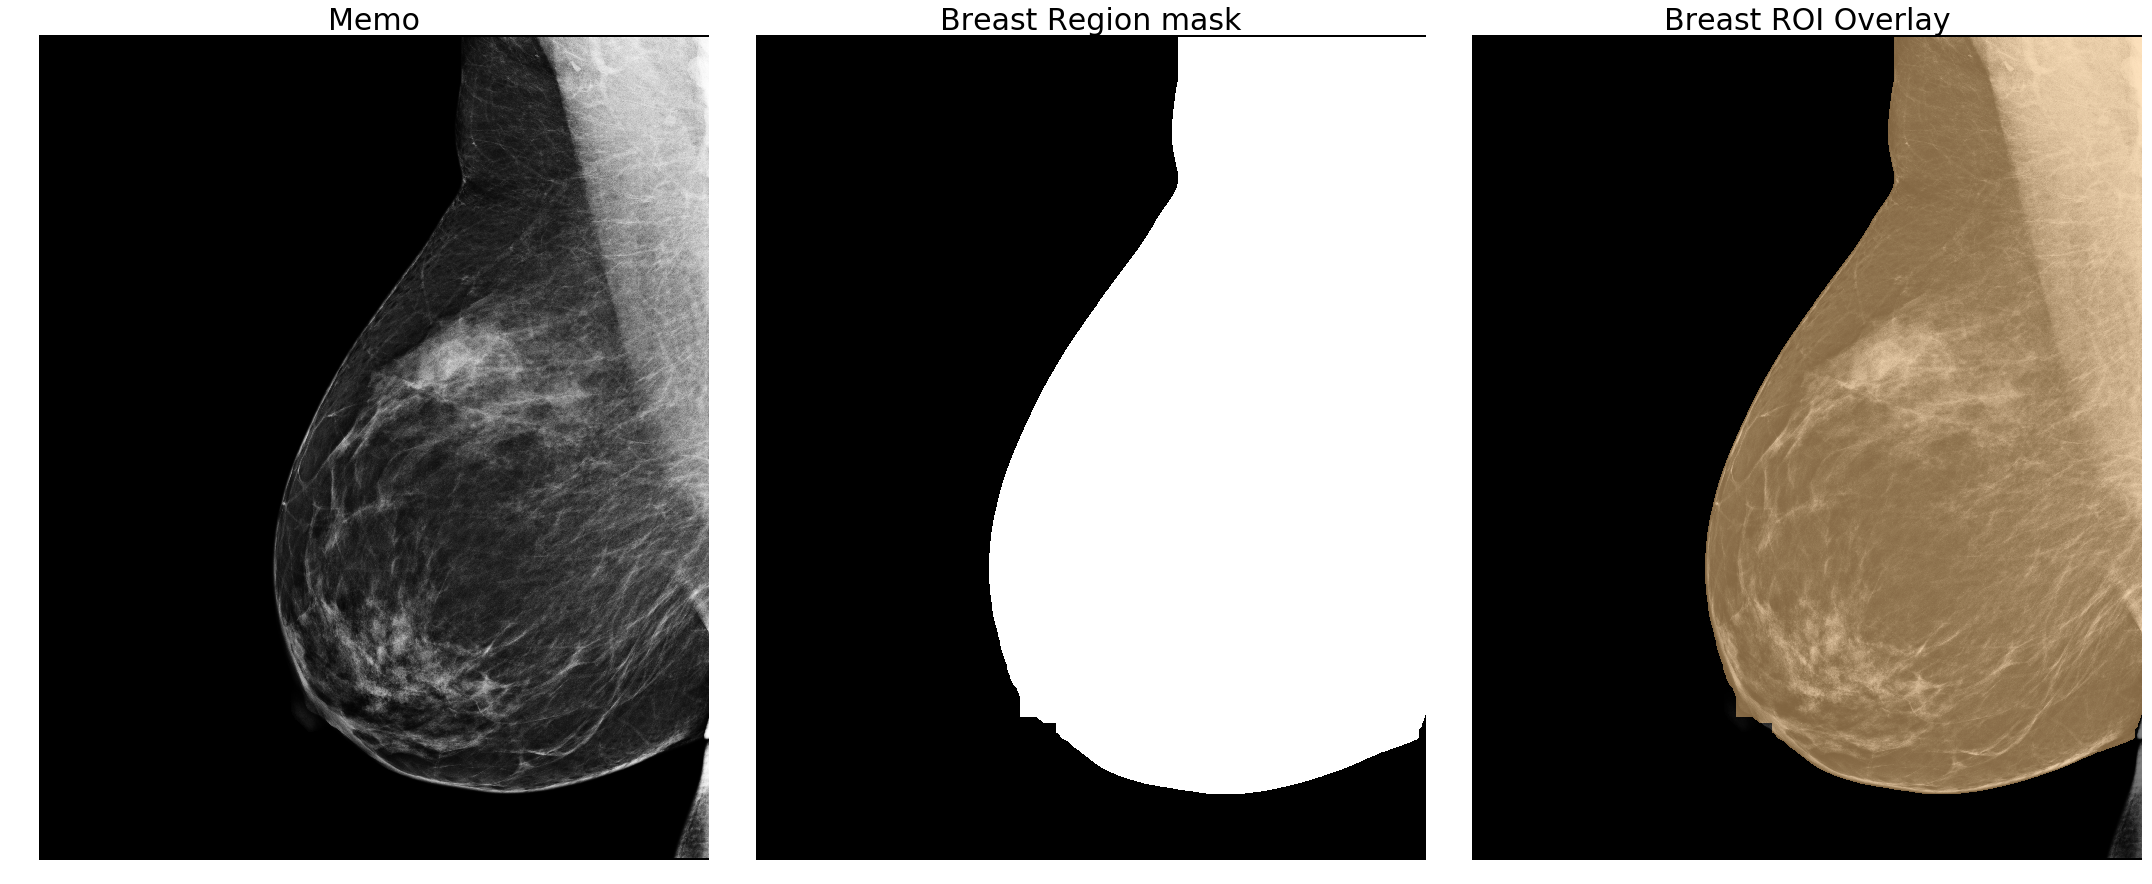

In [4]:
## import Libararies
import cv2
import numpy as np
import os, glob
import sys
import pydicom
from scipy.misc import imsave,imread
import pandas as pd
from skimage import measure
from skimage.measure import label
import matplotlib.pyplot as plt

## Getting The Brest_Refion_using_Connected_Component_Analaysis
def select_largest_obj(img_bin, lab_val=255, smooth_boundary=False, kernel_size=15):
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab_roi = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask_roi = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask_roi[img_labeled == largest_obj_lab_roi] = lab_val
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask_roi = cv2.morphologyEx(largest_mask_roi, cv2.MORPH_OPEN, kernel_)
    return largest_mask_roi

## Dicom Fliping_name
def Flip_memo(dicom_file):
    img=dicom_file.pixel_array
    try:
        flip=dicom_file[0x0018,0x7034].value.lower()
        if 'y' in flip:
            img=np.fliplr(img)
    except:
        pass
    return img

## Generate Breast Region Bases on Threshold Image
def Generate_Brest_roi_mask(dcm_img):
    Threshold_img = np.array(dcm_img, dtype=np.uint8)
    mask = select_largest_obj(Threshold_img , lab_val=255, smooth_boundary=True, kernel_size=15)
    #Erosion
    Erosion_kernel = np.ones((125,125),np.uint8)
    Erosion = cv2.erode(mask,Erosion_kernel,iterations =1)
    #Label-The Image
    lab_mask_init = label(Erosion,background=0)
    lab_ind,counts_ind = np.unique(lab_mask_init,return_counts  = True)
    #-Shorting the label
    uni_feat,counts_feat = np.unique(lab_mask_init,return_counts = True)
    sorted_feat = uni_feat[np.flipud(np.argsort(counts_feat))]
    sorted_counts = np.flipud(np.sort(counts_feat))
    
    if sorted_feat[0]==0:
        memo_region_index=sorted_feat[1]
    else:
        memo_region_index=sorted_feat[0]
    black=np.where((lab_mask_init!=memo_region_index))
    #black=np.where((lab_mask_init!=1))
    Erosion[black]=0
    # Finally Filling some regions
    Erosion=Erosion.astype('bool').astype('uint8')
    Dilat_kernel= np.ones((125,125),np.uint8)
    dilat = cv2.dilate(Erosion,Dilat_kernel,iterations =1)
    # if you want to refine the mask more than do one more step dilation
    #Dilat_kernel2= np.ones((10,10),np.uint8)
    #Dilat_kernel2=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))
    #dilat = cv2.dilate(dilat,Dilat_kernel2,iterations =1)
    return dilat

def Ploting_function(dcm,dcm_roi):

    f, axarr = plt.subplots(1,3,figsize=(30,30));
    axarr[0].imshow(dcm, cmap=plt.cm.gray);
    axarr[0].axis('off')
    axarr[0].set_title('Memo',fontsize = 30)

    axarr[1].imshow(dcm_roi, cmap='gray',alpha=1);
    axarr[1].axis('off')
    axarr[1].set_title('Breast Region mask',fontsize = 30)

    axarr[2].imshow(dcm, cmap='gray',alpha=1);
    axarr[2].imshow(dcm_roi, cmap='copper',alpha=0.5);
    axarr[2].axis('off')
    axarr[2].set_title('Breast ROI Overlay',fontsize = 30)

    plt.tight_layout()
    #plt.close()
    return



one_dcm='1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.532.0.dcm'
ds  =pydicom.read_file(one_dcm)
dcm = Flip_memo(ds)
ret,thresh = cv2.threshold(dcm,60,255,0)
Breast_roi=Generate_Brest_roi_mask(thresh)
Ploting_function(dcm,Breast_roi)

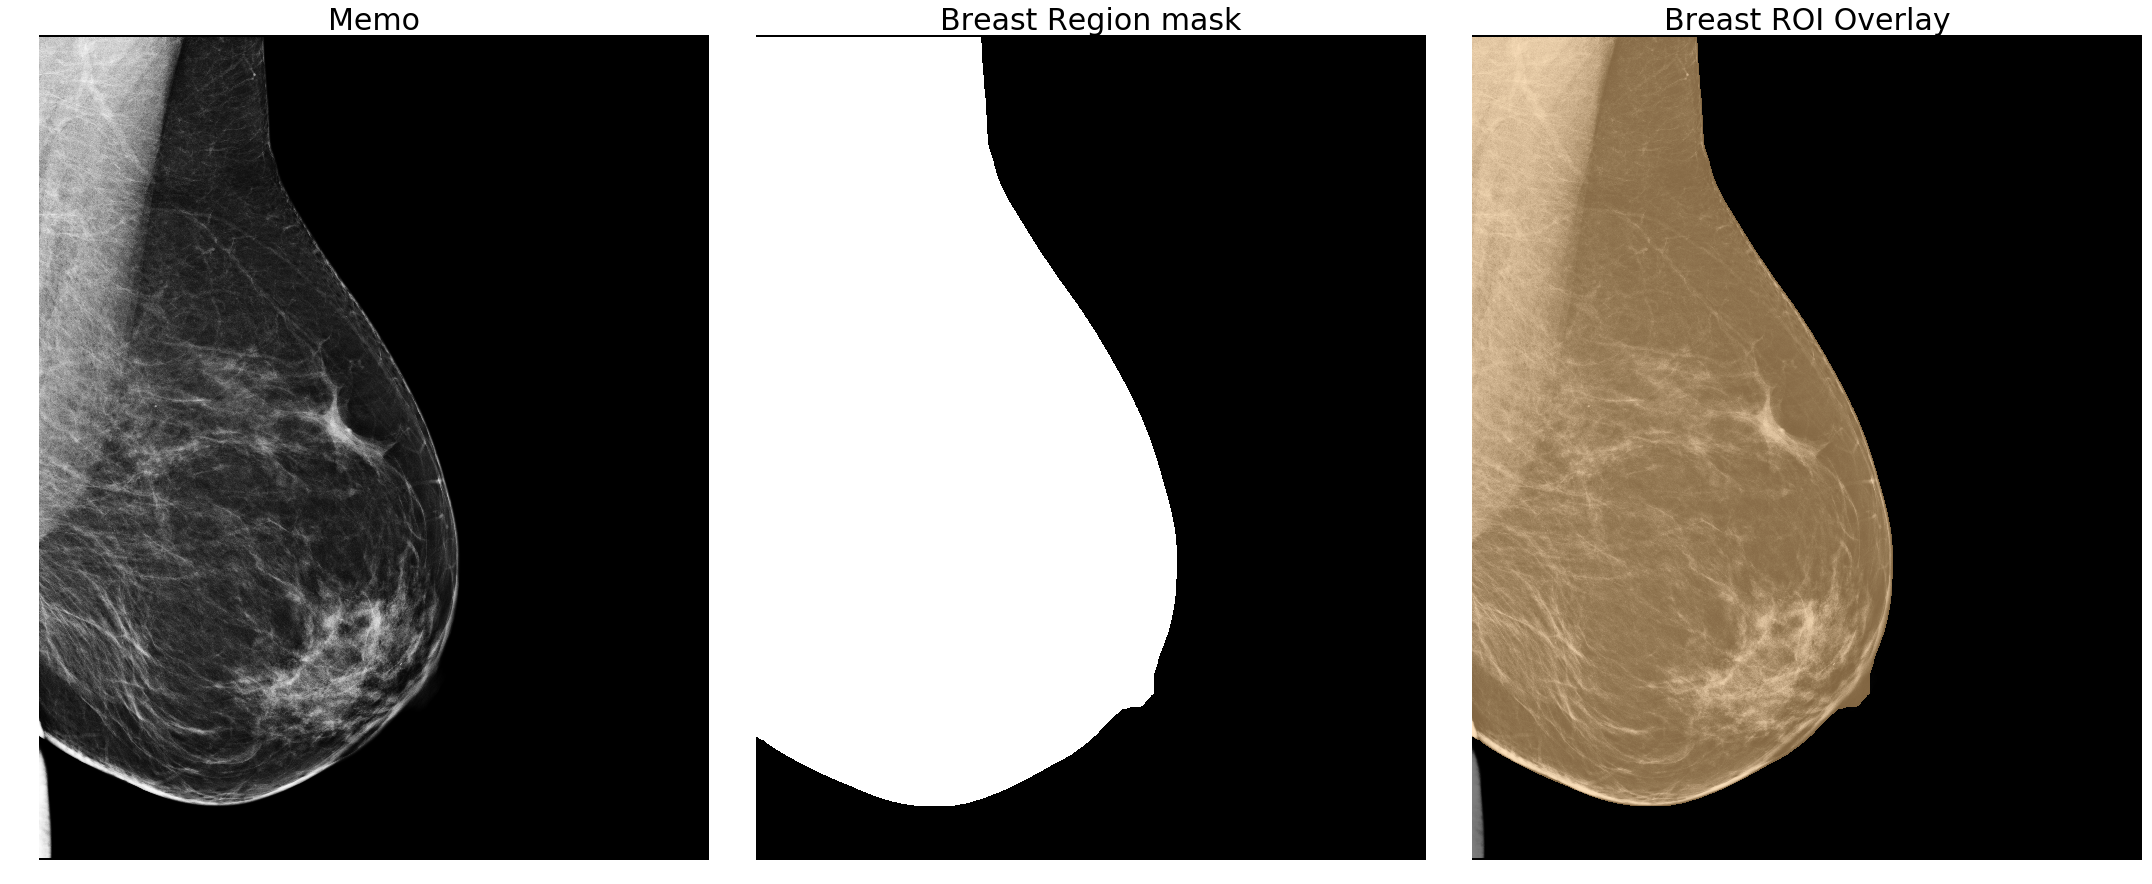

In [2]:
one_dcm='1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.526.0.dcm'
ds  =pydicom.read_file(one_dcm)
dcm = Flip_memo(ds)
#-- Threshold is different for differet vendors so check before using the values
ret,thresh = cv2.threshold(dcm,60,255,0)
Breast_roi=Generate_Brest_roi_mask(thresh)
Ploting_function(dcm,Breast_roi)

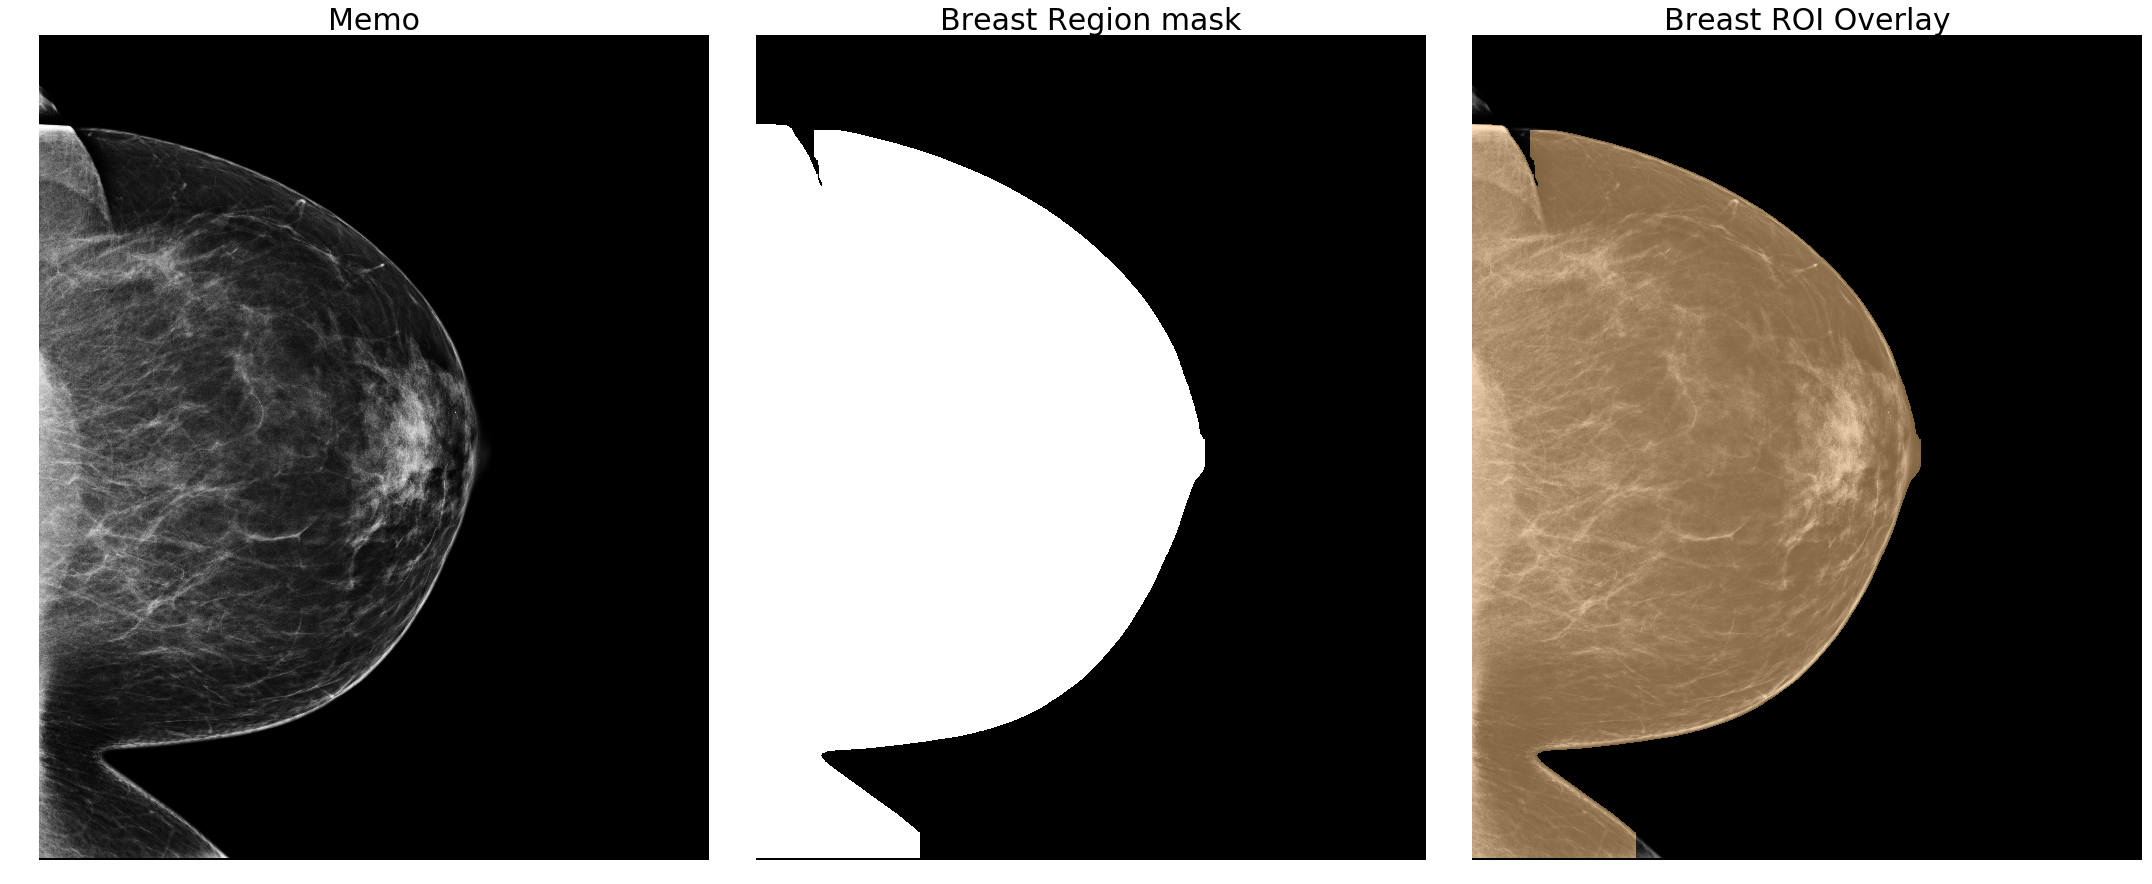

In [3]:
one_dcm='1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.522.0.dcm'
ds  =pydicom.read_file(one_dcm)
dcm = Flip_memo(ds)
ret,thresh = cv2.threshold(dcm,60,255,0)
Breast_roi=Generate_Brest_roi_mask(thresh)
Ploting_function(dcm,Breast_roi)